# Evaluating How Liberal vs. Conservative Opinion News Shows Influenced the Narrative about the COVID-19 Pandemic

**Group Members: Jennifer Andre, Tobi Jegede, Callie Lambert, & Lori Zakalik**

**Date**: May 2, 2022

**Disclaimer:** The runtime for our notebook is approximately **INSERT TIME HERE** minutes/hours. In order to run our team's notebook, please make sure you have the following python libraries and packages installed on your device:
* glob
* os
* matplotlib.pyplot
* numpy
* string
* regex
* sklearn.feature_extraction
* operator
* collections
* spacy
* sklearn.decomposition
* wordcloud
* ntlk.sentiment
    *  Note: If you run into issues after downloading the above package (ntlk.sentiment), please use the code chunk below: 
    
        ```python
        import nltk 
        import ssl
        try: 
            _create_unverified_https_context = ssl._create_unverified_context
        except AttributeError:
            pass
        else:
            ssl._create_default_https_context = _create_unverified_https_context 
            
        nltk.download('vader_lexicon')
        ```

# Table of Contents
1. [Background](#background)
    1. [Explanation of the Data](#data)
2. [Setup & Data Pre-Processing](#setup)
    1. [Load Data](#load)
    2. [Define COVID Terms](#terms)
    3. [Update Stop Words](#stop)
    4. [Read in, Clean, & Store Cleaned Transcripts](#read)
    5. [Store Transcripts by Year](#year)
3. [Analysis #1: Word Frequency Analysis](#a1)
    1. [Liberal - Full Transcript Set](#a1liberalfull)
    2. [Conservative - Full Transcript Set](#a1conservativefull)
    3. **placeholder for year stuff**
4. [Analysis #2: Co-Occurrence Analysis](#a2)
    1. [Liberal - Transcript Co-Occurrence](#a2liberaltrans)
    2. [Conservative - Transcript Co-Occurrence](#a2conservativetrans)
    3. [Liberal - Sentence Co-Occurrence](#a2liberalsents)
    4. [Conservative - Sentence Co-Occurrence](#a2conservativesents)
5. [Analysis #3: Topic Modeling](#a3)
    1. [Liberal - Transcript Topic Modeling](#a3liberaltrans)
    2. [Conservative - Transcript Topic Modeling](#a3conservativetrans)
6. [Analysis #4: Sentiment Analysis](#a4)
    1. **placeholder**
7. [Policy Implications](#policy)
8. [Future Work & Analysis Limitations](#future)

# Background <a name="background"></a>

## Explanation of the Data <a name="data"></a>

As mentioned in our Final Project Proposal, we wanted to specifically analyze how the different **opinion** news arms of popular cable news channels talked about the COVID-19 pandemic. 

Using some research from the Pew Research Center, we found that CNN and MSNBC were the most popular news channels watched by individuals who consistently voted for liberal political candidates, while Fox News was the most watched cable news channel for individuals who consistently voted for conservaive political candidates. 

We then found additional articles that provided information on the most watched tv shows on CNN, MSNBC, and Fox News and found that Anderson Cooper 360 was the most watched show on CNN, Rachel Maddow was the most watched show on MSNBC, and Tucker Carlson and the Five were the most watched shows on Fox News. 

We then used webscraping techniques to pull the text files for the transcripts for each of the shows mentioned above from March 2020 to March 2022. The code to run this webscraping can be found in the code folder on our project's GitHub page, located here: https://github.com/tobijegede/opinion-news-nlp 



# Setup & Data Pre-Processing <a name="setup"></a>

In [1]:
#import packages & libraries
import glob 
import os
import matplotlib.pyplot as plt
import numpy as np
import string
import regex as re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter
from collections import Counter
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from matplotlib.ticker import PercentFormatter

## Load Data <a name="load"></a>

**Disclaimer:** You may need to adjust the code chunk below to properly load in the data. Our current file structure is:
- Code Repository Folder (opinion-news-nlp)
    - data
        - 01-raw
            - name of opinion news show
                - a list of text files

In [2]:

#get the correct file path starting file path
repo_path = os.path.dirname(os.getcwd()) 

#read in the liberal corpus
rm_paths = glob.glob(repo_path + "/data/01-raw/rachel_maddow/*.txt") #the paths for the rachel maddow transcript files
ac_paths = glob.glob(repo_path + "/data/01-raw/anderson_cooper/*.txt") #the paths for the anderson cooper transcript files
all_liberal_files = rm_paths + ac_paths # all liberal trasncripts

#read in the conservative corpus 
tc_paths = glob.glob(repo_path + "/data/01-raw/tucker_carlson/*.txt") #the paths for the tucker carlson transcript files
tf_paths = glob.glob(repo_path + '/data/01-raw/the_five/*.txt') #the paths for the five transcript files
all_conservative_files = tc_paths + tf_paths #all conservative transcripts

#read in the CDC transcripts
cdc_paths = glob.glob(repo_path + "/data/01-raw/cdc_press_releases/*.txt") #the paths for cdc transcript files


The basic summary statistics for all of the data that we used in our analysis is as follows:
1. Conservative Corpus, N = 458
    - Tucker Carlson, 208
    - The Five, 250
2. Liberal Corpus, N = 1,008
    - Anderson Cooper, 530
    - Rachel Maddow, 478
3. CDC, N = 47


It is important to note that there are fewer conservative transcripts in the corpus. Fox News does not have transcripts available for every show (e.g., Tucker Carlson airs every weeknight, but there are only transcripts available for 1-2 shows per week). Although this a limitation, the conservative corpus still provided a large amount of unstructured data to compare against the liberal corpus. **<<*add info about script length*>>**

## Define COVID Terms <a name="terms"></a>

In the below, we created lists of words to use to help with co-occurrence analysis later on in our notebook. We specifically wanted to catalog most of the ways that COVID, mask, and vaccine words could potentially show up in the transcripts in the dataset.

In [ ]:
# covid terms
covid_terms = ['coronavirus', 'covid', 'covid-19', 'covid-', 
               'covid19', 'virus', 'sars', 'sars-', 'sars-cov-2', 'sarscov2']

In [4]:
# vaccine terms
vaccine_terms = ['vaccine', 'vaccination', 'vaccinated', 'mrna', 'booster', 'vax', 'vaxx', 
                 'vaxxed', 'pfizer', 'moderna', 'johnson', 'j&j', 'jj', 'biontech', 'pfizerbiontech', 
                 'astra', 'zeneca', 'astrazeneca', 'oxford', 'astrazenecaoxford']

In [5]:
# mask terms
mask_terms = ['mask', 'masking', 'n95', 'kn95', 'n']

In [6]:
# other COVID-related terms
other_terms = ['china', 'wuhan', 'mandate', 'pandemic', 'epidemic', 'virus',
               'distancing', 'spread', 'immunity', 'incubation', 'quarantine']

all_covid_terms = covid_terms + other_terms

## Update Stop Words <a name="stop"></a>

In the code chunk below, we add specific stop words for the conservative, liberal, and CDC news sources in order to remove named entities, like the names of the talk show hosts, as well as the name of the CDC, from the list of relevant words to count.

In [7]:
# add network, host names for conservative news corpus
add_stop_words_conservative = ['tucker', 'carlson', 'fox', 'news', 'five', 
                               'greg', 'gutfeld', 'dana', 'perino', 'jesse', 'watters',
                               'jeanine', 'pirro', 'geraldo', 'rivera', 'jessica', 'tarlov',
                               'harold', 'ford', 'jr', 'ok', 'williams',  'pavlich',
                               'anthony', 'tony', 'fauci', 'faucis', 'dr',
                               'mcdowell', 'juan', 'thanks', 'crosstalk', 'unidentified',
                               'video', 'clip', 'voiceover', 'videotape']

# add host names, important figures for the liberal news corpus
add_stop_words_liberal = ['anderson', 'cooper', 'rachel', 'maddow',
                          'chris', 'hayes', 'ari', 'berman', 'michael', 'osterholm',
                          'cnn', 'msnbc', 'cnns', 'msnbcs',
                          'vivek', 'murthy', 'rochelle', 'walensky', 'jerome', 'adams', 'alex', 'azar',
                          'anthony', 'tony', 'fauci', 'faucis', 'dr',
                          'cuomo', 'erin', 'david',
                          'leana', 'wen', 'deborah', 'birx',
                          'robert', 'redfield', 'gavin', 'newsom',
                          'ashish', 'jha', 'tom', 'frieden',
                          'video', 'clip', 'voiceover', 'videotape']

# add common words for the cdc news corpus
add_stop_words_cdc = ['question', 'cdc', "fauci", "dr", "thanks", "thank", "people"]

In [8]:
#create the full list of stop words for each of the corpuses
full_stop_words_conservative = text.ENGLISH_STOP_WORDS.union(add_stop_words_conservative)
full_stop_words_liberal = text.ENGLISH_STOP_WORDS.union(add_stop_words_liberal)
full_stop_words_cdc = text.ENGLISH_STOP_WORDS.union(add_stop_words_cdc)

## Read in, Clean, & Store Cleaned Transcripts <a name="read"></a>

In [9]:
#---------- IMPORTING & CLEANING THE LIBERAL CORPUS
text_transcripts_liberal = [] # container for transcript text
text_sentences_liberal = [] # container for sentence text: NOTE: WILL USE TEXT_SENTENCES FOR THE SENTIMENT ANALYSIS
covid_counts_transcripts_liberal = [] # container for transcript covid mention counts
covid_counts_sentences_liberal  = [] # container for sentence covid mention counts

# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_liberal_files:
    
    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8').read().lower()
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())
    
    # add cleaned text to container
    text_transcripts_liberal.append(corpus_text)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
    covid_counts_transcripts_liberal.append(cov_trans_counter)
    
    
    #### sentences as documents
    for sentence in text.split('.'): # note that splitting on periods is not perfect for identifying sentences
        
        # create sentence covid counter
        cov_sen_counter = 0
        
        ### string cleaning
        corpus_sen = sentence.replace('\xa0', '')
        # remove all punctuation    
        for c in string.punctuation:
            corpus_sen = corpus_sen.replace(c, "")
        # remove numbers            
        corpus_sen = re.sub('\d+', '', corpus_sen)
        # remove whitespaces
        corpus_sen = " ".join(corpus_sen.split())
        
        # add cleaned sentence to container
        text_sentences_liberal.append(corpus_sen)
        
        # add to counter if word in sentence is in covid terms, add count to container
        for word in corpus_sen.split(' '):
            if word in covid_terms:
                cov_sen_counter += 1
        covid_counts_sentences_liberal.append(cov_sen_counter)  

In [10]:
# display simple counts
print("Our liberal news corpus consists of {:,} total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.".format(len(text_transcripts_liberal)))

print("There are {:,} total sentences in the corpus.".format(len(text_sentences_liberal)))

print("There are {:,} transcripts that mention COVID at least once.".format(len(text_transcripts_liberal) - covid_counts_transcripts_liberal.count(0)))

Our liberal news corpus consists of 1,008 total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.
There are 459,365 total sentences in the corpus.
There are 876 transcripts that mention COVID at least once.


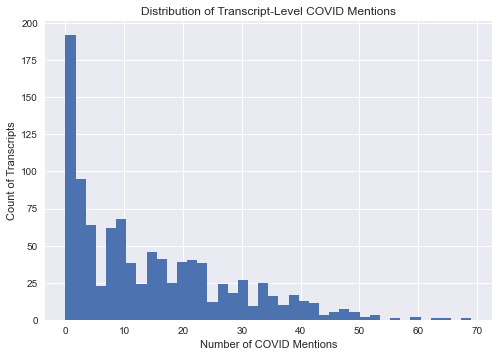

In [11]:
# Distribution of COVID mentions - transcripts
plt.style.use('seaborn')  

fig = plt.figure()
plt.hist(covid_counts_transcripts_liberal, bins = 40)
plt.xlabel('Number of COVID Mentions')
plt.ylabel('Count of Transcripts')
plt.title('Distribution of Liberal Transcript-Level COVID Mentions')

plt.show()

#fig.savefig(repo_path +'/images/liberal-distribution-covid-mentions.png')

In [12]:
#---------- IMPORTING & CLEANING THE CONSERVATIVE CORPUS
text_transcripts_conservative = [] # container for transcript text
text_sentences_conservative = [] # container for sentence text
covid_counts_transcripts_conservative = [] # container for transcript covid mention counts
covid_counts_sentences_conservative = [] # container for sentence covid mention counts

# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_conservative_files:
    
    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8', errors = 'ignore').read().lower()  # Lori ignored a few characters that were not ASCII
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())
    
    # add cleaned text to container
    text_transcripts_conservative.append(corpus_text)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
    covid_counts_transcripts_conservative.append(cov_trans_counter)
    
    
    #### sentences as documents
    for sentence in text.split('.'): # note that splitting on periods is not perfect for identifying sentences
        
        # create sentence covid counter
        cov_sen_counter = 0
        
        ### string cleaning
        corpus_sen = sentence.replace('\xa0', '')
        # remove all punctuation    
        for c in string.punctuation:
            corpus_sen = corpus_sen.replace(c, "")
        # remove numbers            
        corpus_sen = re.sub('\d+', '', corpus_sen)
        # remove whitespaces
        corpus_sen = " ".join(corpus_sen.split())
        
        # add cleaned sentence to container
        text_sentences_conservative.append(corpus_sen)
        
        # add to counter if word in sentence is in covid terms, add count to container
        for word in corpus_sen.split(' '):
            if word in covid_terms:
                cov_sen_counter += 1
        covid_counts_sentences_conservative.append(cov_sen_counter) 

In [13]:
# display simple counts
print("Our conservative news corpus consists of {:,} total transcripts, sourced from Tucker Carlson Tonight and The Five.".format(len(text_transcripts_conservative)))

print("There are {:,} total sentences in the corpus.".format(len(text_sentences_conservative)))

print("There are {:,} transcripts that mention COVID at least once.".format(len(text_transcripts_conservative) - covid_counts_transcripts_conservative.count(0)))

Our conservative news corpus consists of 458 total transcripts, sourced from Tucker Carlson Tonight and The Five.
There are 254,010 total sentences in the corpus.
There are 434 transcripts that mention COVID at least once.


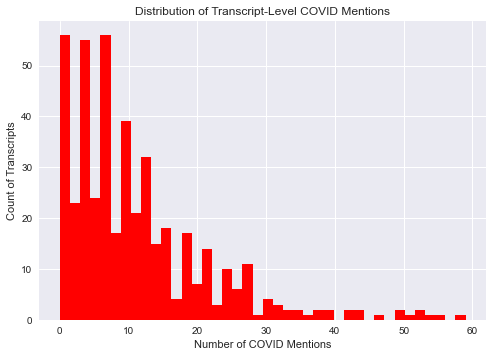

In [14]:
# Distribution of COVID mentions - transcripts
plt.style.use('seaborn')  

fig = plt.figure()
plt.hist(covid_counts_transcripts_conservative, bins = 40, color = 'red')
plt.xlabel('Number of COVID Mentions')
plt.ylabel('Count of Transcripts')
plt.title('Distribution of Conservative Transcript-Level COVID Mentions')

plt.show()

#fig.savefig(repo_path +'/images/conservative-distribution-covid-mentions.png')

In [15]:
#import CDC corpus

## Store Transcripts by Year <a name="year"></a>

# Analysis #1: Word Frequency Analysis <a name="a1"></a>

In order to get a high level picture of the datasets that we had available, and to do a basic sense check, we first conducted word frequency analysis using sklearn's Count Vectorizer and

In [16]:
# set up count vectorizer function
def countvec(text_list, stop_words):
    
    # step 1: set up the vectorizer
    vectorizer = CountVectorizer(min_df = 0.05, 
                                 stop_words = stop_words, 
                                 max_df = 0.8)
    
    # step 2: apply the vectorizer to the corpus of documents and store in document matrix X
    X = vectorizer.fit(text_list)
    
    # step 3: fit transform corpus of documents
    X_transformed = vectorizer.fit_transform(text_list)
    
    # step 4: extract feature names and counts, create dictionary
    array_of_words = vectorizer.get_feature_names_out()
    array_of_counts = X_transformed.toarray().sum(axis = 0)
    word_frequency_dictionary = dict(zip(array_of_words, array_of_counts))
    
    return(X, X_transformed, array_of_words, array_of_counts, word_frequency_dictionary)

## Liberal - Full Transcript Set <a name="a1liberalfull"></a>

In [17]:
# apply function to full transcript set
X_trans_liberal, X_transformed_trans_liberal, array_of_words_trans_liberal, array_of_counts_trans_liberal, word_frequency_dictionary_trans_liberal = countvec(text_transcripts_liberal, full_stop_words_liberal)

In [18]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_liberal.vocabulary_)))

There are 4,867 unique words in the vocabulary.


In [19]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans_liberal.vocabulary_

vocab['coronavirus']

978

In [20]:
# set number of top words to see
num_top_words = 10

top_10_words_liberal = dict(sorted(word_frequency_dictionary_trans_liberal.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_liberal)

{'republicans': 6011, 'police': 5514, 'health': 5366, 'vote': 5239, 'justice': 5228, 'court': 5171, 'vaccine': 5035, 'senate': 4960, 'department': 4889, 'york': 4840}


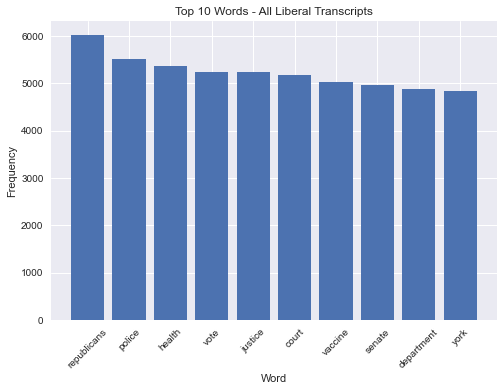

In [21]:
# plot top words
plt.style.use('seaborn')  

fig = plt.figure()

x = top_10_words_liberal.keys()
y = top_10_words_liberal.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - All Liberal Transcripts')

plt.show()

#fig.savefig(repo_path +'/images/liberal-top-words.png')

## Conservative - Full Transcript Set <a name="a1conservativefull"></a>

In [22]:
# apply function to full transcript set
X_trans_conservative, X_transformed_trans_conservative, array_of_words_trans_conservative, array_of_counts_trans_conservative, word_frequency_dictionary_trans_conservative = countvec(text_transcripts_conservative, full_stop_words_conservative)

In [23]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_conservative.vocabulary_)))

There are 5,029 unique words in the vocabulary.


In [24]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans_conservative.vocabulary_

vocab['coronavirus']

1007

In [25]:
# set number of top words to see
num_top_words = 10

top_10_words_conservative = dict(sorted(word_frequency_dictionary_trans_conservative.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_conservative)

{'police': 2669, 'administration': 1647, 'kids': 1617, 'school': 1612, 'black': 1605, 'quote': 1566, 'vaccine': 1556, 'china': 1511, 'crime': 1501, 'border': 1475}


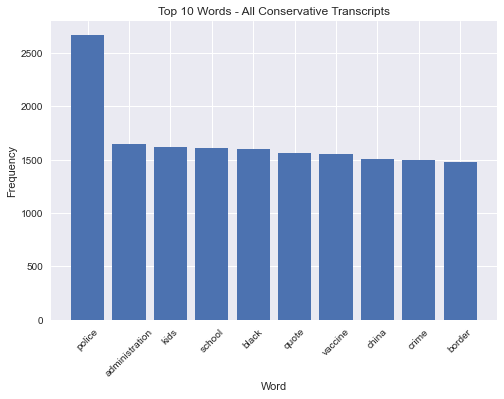

In [26]:
# plot top words
plt.style.use('seaborn')  

fig = plt.figure()

x = top_10_words_conservative.keys()
y = top_10_words_conservative.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - All Conservative Transcripts')

plt.show()

#fig.savefig(repo_path +'/images/conservative-top-words.png')

# Analysis #2: Co-Occurrence Analysis <a name="a2"></a>

## Liberal - Transcript Co-Occurrence <a name="a2liberaltrans"></a>

In [27]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [28]:
%%time
# nlp parse transcripts
nlp_list_trans_liberal = [nlp(text) for text in text_transcripts_liberal]

CPU times: total: 8min 28s
Wall time: 8min 30s


In [29]:
# create counters
lemma_counter = Counter()
covid_co_counter = Counter()
covid_count = 0
mask_co_counter = Counter()
mask_count = 0
vaccine_co_counter = Counter()
vaccine_count = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for transcript in nlp_list_trans_liberal:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counter.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter.update(lemmas)
        covid_count += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter.update(lemmas)
        mask_count += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter.update(lemmas)
        vaccine_count += 1

In [30]:
# calculate COVID terms PMI
# P(covid)
covid_ratio = covid_count / len(nlp_list_trans_liberal)

# calculate PMI only for words that co-occur
pmi_covid = list()
for lemma, count in covid_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans_liberal) # P(lemma)
    co_ratio = covid_co_counter[lemma] / len(nlp_list_trans_liberal) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid += [(lemma, lemma_counter[lemma], covid_co_counter[lemma], 
                   np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort = sorted(pmi_covid, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [31]:
# calculate mask terms PMI
# P(mask)
mask_ratio = mask_count / len(nlp_list_trans_liberal)

# calculate PMI only for words that co-occur
pmi_mask = list()
for lemma, count in mask_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans_liberal) # P(lemma)
    co_ratio = mask_co_counter[lemma] / len(nlp_list_trans_liberal) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask += [(lemma, lemma_counter[lemma], mask_co_counter[lemma], 
                   np.log2(co_ratio / (mask_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort = sorted(pmi_mask, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [32]:
# calculate vaccine terms PMI
# P(vaccine)
vaccine_ratio = vaccine_count / len(nlp_list_trans_liberal)

# calculate PMI only for words that co-occur
pmi_vaccine = list()
for lemma, count in vaccine_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans_liberal) # P(lemma)
    co_ratio = vaccine_co_counter[lemma] / len(nlp_list_trans_liberal) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine += [(lemma, lemma_counter[lemma], vaccine_co_counter[lemma], 
                   np.log2(co_ratio / (vaccine_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort = sorted(pmi_vaccine, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [33]:
# print top words (by PMI) that co-occur with COVID terms - break ties arbitrarily
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in covid_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
infection                 432             432             0.20249        
symptom                   263             263             0.20249        
epidemic                  241             241             0.20249        
variant                   232             232             0.20249        
icu                       217             217             0.20249        
indoor                    185             185             0.20249        
ventilator                175             175             0.20249        
antibody                  152             152             0.20249        
unvaccinated              136             136             0.20249        
contagious                130             130             0.20249        
ppe                       124             124             0.20249        
asymptomatic              99             

In [34]:
# print top words (by PMI) that co-occur with COVID terms given that lemma count > 30% of transcripts
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in covid_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
infection                 432             432             0.20249        
hospitalization           355             354             0.19842        
cdc                       382             380             0.19492        
infect                    405             402             0.19177        
testing                   376             372             0.18706        
disease                   464             459             0.18686        
vaccine                   619             610             0.18136        
vaccination               320             315             0.17977        
sick                      448             437             0.16663        
surge                     359             350             0.16586        
science                   391             381             0.16512        
vaccinate                 385            

In [35]:
# print top words (by PMI) that co-occur with mask terms - break ties arbitrarily
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in mask_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
antigen                   24              24              0.76783        
meatpacking               23              23              0.76783        
reuse                     22              22              0.76783        
remdesivir                21              21              0.76783        
ihme                      19              19              0.76783        
floridian                 19              19              0.76783        
sebelius                  17              17              0.76783        
reagent                   16              16              0.76783        
stayat                    15              15              0.76783        
asthma                    15              15              0.76783        
facemask                  15              15              0.76783        
denmark                   14             

In [36]:
# print top words (by PMI) that co-occur with mask terms given that lemma count > 30% of transcripts
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in mask_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
testing                   376             319             0.53065        
infection                 432             350             0.46415        
wear                      611             484             0.43166        
infect                    405             319             0.42346        
disease                   464             364             0.41764        
hospitalization           355             278             0.41509        
patient                   432             338             0.41382        
virus                     582             454             0.4095         
science                   391             302             0.39521        
surge                     359             276             0.38851        
positive                  469             360             0.38624        
distance                  312            

In [37]:
# print top words (by PMI) that co-occur with vaccine terms - break ties arbitrarily
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in vaccine_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
unvaccinated              136             136             0.52195        
transmissible             71              71              0.52195        
unvaccinate               66              66              0.52195        
placebo                   39              39              0.52195        
immunization              34              34              0.52195        
immunocompromise          30              30              0.52195        
epidemiology              27              27              0.52195        
lyndon                    24              24              0.52195        
uptake                    23              23              0.52195        
satan                     23              23              0.52195        
merck                     22              22              0.52195        
transmissibility          22             

In [38]:
# print top words (by PMI) that co-occur with vaccine terms given that lemma count > 30% of transcripts
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in vaccine_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
vaccinate                 385             374             0.48013        
cdc                       382             322             0.27544        
science                   391             327             0.26407        
hospitalization           355             296             0.25973        
disease                   464             386             0.25643        
infection                 432             356             0.2428         
infect                    405             331             0.23086        
datum                     550             444             0.21308        
study                     418             337             0.2112         
shot                      467             376             0.20926        
virus                     582             468             0.20744        
burnett                   322            

## Conservative - Transcript Co-Occurrence <a name="a2conservativetrans"></a>

In [39]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [40]:
%%time
# nlp parse transcripts
nlp_list_trans_conservative = [nlp(text) for text in text_transcripts_conservative]

CPU times: total: 3min 49s
Wall time: 3min 50s


In [41]:
# create counters
lemma_counter = Counter()
covid_co_counter = Counter()
covid_count = 0
mask_co_counter = Counter()
mask_count = 0
vaccine_co_counter = Counter()
vaccine_count = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for transcript in nlp_list_trans_conservative:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counter.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter.update(lemmas)
        covid_count += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter.update(lemmas)
        mask_count += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter.update(lemmas)
        vaccine_count += 1

In [42]:
# calculate COVID terms PMI
# P(covid)
covid_ratio = covid_count / len(nlp_list_trans_conservative)

# calculate PMI only for words that co-occur
pmi_covid = list()
for lemma, count in covid_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans_conservative) # P(lemma)
    co_ratio = covid_co_counter[lemma] / len(nlp_list_trans_conservative) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid += [(lemma, lemma_counter[lemma], covid_co_counter[lemma], 
                   np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort = sorted(pmi_covid, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [43]:
# calculate mask terms PMI
# P(mask)
mask_ratio = mask_count / len(nlp_list_trans_conservative)

# calculate PMI only for words that co-occur
pmi_mask = list()
for lemma, count in mask_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans_conservative) # P(lemma)
    co_ratio = mask_co_counter[lemma] / len(nlp_list_trans_conservative) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask += [(lemma, lemma_counter[lemma], mask_co_counter[lemma], 
                   np.log2(co_ratio / (mask_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort = sorted(pmi_mask, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [44]:
# calculate vaccine terms PMI
# P(vaccine)
vaccine_ratio = vaccine_count / len(nlp_list_trans_conservative)

# calculate PMI only for words that co-occur
pmi_vaccine = list()
for lemma, count in vaccine_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans_conservative) # P(lemma)
    co_ratio = vaccine_co_counter[lemma] / len(nlp_list_trans_conservative) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine += [(lemma, lemma_counter[lemma], vaccine_co_counter[lemma], 
                   np.log2(co_ratio / (vaccine_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort = sorted(pmi_vaccine, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [45]:
# print top words (by PMI) that co-occur with COVID terms - break ties arbitrarily
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in covid_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
science                   250             250             0.07765        
lockdown                  148             148             0.07765        
infect                    136             136             0.07765        
infection                 118             118             0.07765        
criticism                 107             107             0.07765        
testing                   102             102             0.07765        
quarantine                102             102             0.07765        
infectious                98              98              0.07765        
scientific                94              94              0.07765        
distancing                92              92              0.07765        
boss                      89              89              0.07765        
cdc                       89             

In [49]:
# print top words (by PMI) that co-occur with COVID terms given that lemma count > 30% of transcripts
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in covid_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
science                   250             250             0.07765        
lockdown                  148             148             0.07765        
disease                   207             206             0.07067        
mask                      331             329             0.06891        
research                  152             151             0.06813        
vaccine                   270             268             0.06693        
travel                    182             180             0.06171        
vaccinate                 178             176             0.06135        
positive                  170             168             0.06058        
teach                     163             161             0.05984        
institute                 151             149             0.05842        
teacher                   148            

In [50]:
# print top words (by PMI) that co-occur with mask terms - break ties arbitrarily
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in mask_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
maskless                  32              32              0.45983        
surgical                  17              17              0.45983        
attendant                 17              17              0.45983        
bowser                    16              16              0.45983        
illusion                  16              16              0.45983        
declassify                16              16              0.45983        
facemask                  15              15              0.45983        
covering                  14              14              0.45983        
muriel                    14              14              0.45983        
amtrak                    14              14              0.45983        
disobey                   13              13              0.45983        
patron                    13             

In [52]:
# print top words (by PMI) that co-occur with mask terms given that lemma count > 30% of transcripts
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in mask_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
wear                      329             286             0.25775        
disease                   207             175             0.21755        
mandate                   200             169             0.21685        
lockdown                  148             124             0.20457        
foot                      170             142             0.20018        
vaccine                   270             225             0.19679        
vaccinate                 178             147             0.18376        
science                   250             205             0.17352        
viewer                    146             119             0.16482        
virus                     282             229             0.15948        
fully                     170             138             0.15896        
ride                      138            

In [53]:
# print top words (by PMI) that co-occur with vaccine terms - break ties arbitrarily
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in vaccine_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
unvaccinated              79              79              0.56774        
unvaccinate               31              31              0.56774        
neurotic                  17              17              0.56774        
jab                       17              17              0.56774        
antivaxxer                17              17              0.56774        
boris                     16              16              0.56774        
gig                       15              15              0.56774        
hesitancy                 15              15              0.56774        
positivity                14              14              0.56774        
antivax                   14              14              0.56774        
neanderthal               14              14              0.56774        
georgetown                13             

In [55]:
# print top words (by PMI) that co-occur with vaccine terms given that lemma count > 30% of transcripts
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in vaccine_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
vaccinate                 178             170             0.5014         
mandate                   200             178             0.39962        
com                       182             146             0.24977        
viq                       284             223             0.21889        
transcription             284             223             0.21889        
fully                     170             133             0.21363        
immigrant                 141             110             0.20955        
nearly                    187             143             0.18072        
science                   250             191             0.17939        
shot                      215             163             0.16828        
represent                 172             130             0.16384        
natural                   139            

## Liberal - Sentence Co-Occurrence <a name="a2liberalsents"></a>

In [56]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [57]:
# split sentences into batches
text_sentences_batches_liberal = np.array_split(text_sentences_liberal, 10)

In [58]:
%%time
# nlp parse batches
nlp_list_sen_liberal = []
for batch in text_sentences_batches_liberal:
    print('working') # will print 10 times total
    for sentence in batch:
        nlp_list_sen_liberal.append(nlp(str(sentence)))

working
working
working
working
working
working
working
working
working
working
CPU times: total: 24min 8s
Wall time: 24min 34s


In [59]:
# create counters
lemma_counter = Counter()
covid_co_counter = Counter()
covid_count = 0
mask_co_counter = Counter()
mask_count = 0
vaccine_co_counter = Counter()
vaccine_count = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for sentence in nlp_list_sen_liberal:
    lemmas = {token.lemma_.lower() for token in sentence}
    lemma_counter.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter.update(lemmas)
        covid_count += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter.update(lemmas)
        mask_count += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter.update(lemmas)
        vaccine_count += 1

In [60]:
# calculate COVID terms PMI
# P(covid)
covid_ratio = covid_count / len(nlp_list_sen_liberal)

# calculate PMI only for words that co-occur
pmi_covid = list()
for lemma, count in covid_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen_liberal) # P(lemma)
    co_ratio = covid_co_counter[lemma] / len(nlp_list_sen_liberal) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid += [(lemma, lemma_counter[lemma], covid_co_counter[lemma], 
                   np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort = sorted(pmi_covid, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [61]:
# calculate mask terms PMI
# P(mask)
mask_ratio = mask_count / len(nlp_list_sen_liberal)

# calculate PMI only for words that co-occur
pmi_mask = list()
for lemma, count in mask_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen_liberal) # P(lemma)
    co_ratio = mask_co_counter[lemma] / len(nlp_list_sen_liberal) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask += [(lemma, lemma_counter[lemma], mask_co_counter[lemma], 
                   np.log2(co_ratio / (mask_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort = sorted(pmi_mask, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [62]:
# calculate vaccine terms PMI
# P(vaccine)
vaccine_ratio = vaccine_count / len(nlp_list_sen_liberal)

# calculate PMI only for words that co-occur
pmi_vaccine = list()
for lemma, count in vaccine_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen_liberal) # P(lemma)
    co_ratio = vaccine_co_counter[lemma] / len(nlp_list_sen_liberal) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine += [(lemma, lemma_counter[lemma], vaccine_co_counter[lemma], 
                   np.log2(co_ratio / (vaccine_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort = sorted(pmi_vaccine, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [63]:
# print top words (by PMI) that co-occur with COVID terms - break ties arbitrarity
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in covid_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
nasopharynx               7               7               5.08904        
syncytial                 5               5               5.08904        
reliefbill                3               3               5.08904        
kootenai                  3               3               5.08904        
reactivation              3               3               5.08904        
cov                       3               3               5.08904        
flotus                    3               3               5.08904        
clive                     3               3               5.08904        
largestknown              2               2               5.08904        
rampantly                 2               2               5.08904        
antiparasite              2               2               5.08904        
louvre                    2              

In [64]:
# print top words (by PMI) that co-occur with COVID terms given that lemma count > 0.5% of sentences
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in covid_terms) and (counter < 30) and (lemma[1] > round(0.005 * len(text_sentences_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
pandemic                  2976            577             2.72231        
test                      4286            808             2.68183        
die                       2862            505             2.58637        
vaccine                   6069            957             2.42417        
hospital                  3965            624             2.42133        
death                     3508            510             2.30696        
americans                 2745            378             2.22869        
percent                   3006            329             1.89735        
health                    4975            541             1.88804        
high                      2961            321             1.8836         
care                      3468            354             1.79675        
commercial                4200           

In [65]:
# print top words (by PMI) that co-occur with mask terms - break ties arbitrarily
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in mask_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
threeply                  6               6               6.81069        
wearing                   4               4               6.81069        
brum                      3               3               6.81069        
vapor                     2               2               6.81069        
flipflopping              2               2               6.81069        
polskys                   2               2               6.81069        
shielded                  2               2               6.81069        
psas                      2               2               6.81069        
burgum                    2               2               6.81069        
topoftheline              1               1               6.81069        
californianewsom          1               1               6.81069        
heartwarme                1              

In [66]:
# print top words (by PMI) that co-occur with mask terms given that lemma count > 0.5% of sentences
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in mask_terms) and (counter < 30) and (lemma[1] > round(0.005 * len(text_sentences_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
school                    3160            319             3.50239        
protect                   2313            122             2.56588        
face                      2778            146             2.56068        
governor                  4724            230             2.45039        
child                     2322            105             2.34378        
public                    5037            192             2.0973         
health                    4975            165             1.89653        
virus                     3581            117             1.87491        
percent                   3006            94              1.81165        
county                    3552            110             1.79763        
covid                     6547            201             1.78512        
high                      2961           

In [67]:
# print top words (by PMI) that co-occur with vaccine terms - break ties arbitrarily
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in vaccine_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
jeh                       25              25              5.70714        
onedose                   6               6               5.70714        
resumption                5               5               5.70714        
equitably                 5               5               5.70714        
baines                    5               5               5.70714        
baine                     3               3               5.70714        
singleshot                3               3               5.70714        
rotavirus                 3               3               5.70714        
preferable                3               3               5.70714        
talcum                    3               3               5.70714        
cansino                   3               3               5.70714        
tacos                     3              

In [68]:
# print top words (by PMI) that co-occur with vaccine terms given that lemma count > 0.5% of sentences
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in vaccine_terms) and (counter < 30) and (lemma[1] > round(0.005 * len(text_sentences_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
covid                     6547            796             2.66715        
percent                   3006            261             2.18142        
million                   3646            299             2.09904        
virus                     3581            252             1.87827        
protect                   2313            154             1.79838        
child                     2322            151             1.76439        
americans                 2745            173             1.71918        
mask                      4057            253             1.70394        
school                    3160            189             1.64368        
high                      2961            176             1.6347         
pandemic                  2976            174             1.61093        
health                    4975           

## Conservative - Sentence Co-Occurrence <a name="a2conservativesents"></a>

In [69]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [70]:
# split sentences into batches
text_sentences_batches_conservative = np.array_split(text_sentences_conservative, 10)

In [71]:
%%time
# nlp parse batches
nlp_list_sen_conservative = []
for batch in text_sentences_batches_conservative:
    print('working') # will print 10 times total
    for sentence in batch:
        nlp_list_sen_conservative.append(nlp(str(sentence)))

working
working
working
working
working
working
working
working
working
working
CPU times: total: 11min 48s
Wall time: 12min 5s


In [72]:
# create counters
lemma_counter = Counter()
covid_co_counter = Counter()
covid_count = 0
mask_co_counter = Counter()
mask_count = 0
vaccine_co_counter = Counter()
vaccine_count = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for sentence in nlp_list_sen_conservative:
    lemmas = {token.lemma_.lower() for token in sentence}
    lemma_counter.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter.update(lemmas)
        covid_count += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter.update(lemmas)
        mask_count += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter.update(lemmas)
        vaccine_count += 1

In [73]:
# calculate COVID terms PMI
# P(covid)
covid_ratio = covid_count / len(nlp_list_sen_conservative)

# calculate PMI only for words that co-occur
pmi_covid = list()
for lemma, count in covid_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen_conservative) # P(lemma)
    co_ratio = covid_co_counter[lemma] / len(nlp_list_sen_conservative) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid += [(lemma, lemma_counter[lemma], covid_co_counter[lemma], 
                   np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort = sorted(pmi_covid, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [74]:
# calculate mask terms PMI
# P(mask)
mask_ratio = mask_count / len(nlp_list_sen_conservative)

# calculate PMI only for words that co-occur
pmi_mask = list()
for lemma, count in mask_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen_conservative) # P(lemma)
    co_ratio = mask_co_counter[lemma] / len(nlp_list_sen_conservative) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask += [(lemma, lemma_counter[lemma], mask_co_counter[lemma], 
                   np.log2(co_ratio / (mask_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort = sorted(pmi_mask, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [75]:
# calculate vaccine terms PMI
# P(vaccine)
vaccine_ratio = vaccine_count / len(nlp_list_sen_conservative)

# calculate PMI only for words that co-occur
pmi_vaccine = list()
for lemma, count in vaccine_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen_conservative) # P(lemma)
    co_ratio = vaccine_co_counter[lemma] / len(nlp_list_sen_conservative) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine += [(lemma, lemma_counter[lemma], vaccine_co_counter[lemma], 
                   np.log2(co_ratio / (vaccine_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort = sorted(pmi_vaccine, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [76]:
# print top words (by PMI) that co-occur with COVID terms - break ties arbitrarity
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in covid_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
artificially              4               4               5.7224         
combining                 3               3               5.7224         
mer                       3               3               5.7224         
orthopedist               2               2               5.7224         
karam                     2               2               5.7224         
transmissibility          2               2               5.7224         
frontal                   2               2               5.7224         
raoult                    2               2               5.7224         
didi                      2               2               5.7224         
wellcontrolle             2               2               5.7224         
rubella                   2               2               5.7224         
niaid                     2              

In [77]:
# print top words (by PMI) that co-occur with COVID terms given that lemma count > 0.5% of sentences
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in covid_terms) and (counter < 30) and (lemma[1] > round(0.005 * len(text_sentences_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
vaccine                   1892            321             3.16314        
china                     1413            203             2.92319        
health                    1271            148             2.62011        
case                      2079            211             2.42183        
force                     1298            113             2.20051        
americans                 1740            131             1.99096        
million                   1575            113             1.92145        
mask                      2136            151             1.90011        
number                    2092            137             1.78977        
house                     2391            152             1.74693        
public                    1642            100             1.68502        
wear                      1314           

In [78]:
# print top words (by PMI) that co-occur with mask terms - break ties arbitrarity
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in mask_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
thrice                    4               4               6.88172        
reimplemente              2               2               6.88172        
kn                        2               2               6.88172        
wearer                    2               2               6.88172        
nylon                     2               2               6.88172        
feuding                   2               2               6.88172        
nakedness                 1               1               6.88172        
immolate                  1               1               6.88172        
preston                   1               1               6.88172        
kooky                     1               1               6.88172        
promasker                 1               1               6.88172        
expressionless            1              

In [79]:
# print top words (by PMI) that co-occur with mask terms given that lemma count > 0.5% of sentences
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in mask_terms) and (counter < 30) and (lemma[1] > round(0.005 * len(text_sentences_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
wear                      1314            870             6.28685        
school                    2221            129             2.77596        
child                     1585            92              2.77502        
kid                       1919            99              2.60494        
force                     1298            58              2.39763        
covid                     2377            103             2.3533         
vaccine                   1892            81              2.33588        
public                    1642            60              2.10738        
need                      3892            129             1.96665        
governor                  1448            46              1.90544        
health                    1271            40              1.8919         
everybody                 1727           

In [80]:
# print top words (by PMI) that co-occur with vaccine terms - break ties arbitrarity
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in vaccine_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
modernas                  2               2               6.50331        
stephane                  2               2               6.50331        
bancel                    2               2               6.50331        
compulsory                2               2               6.50331        
rna                       2               2               6.50331        
sms                       2               2               6.50331        
pericarditis              2               2               6.50331        
datalink                  2               2               6.50331        
promandate                2               2               6.50331        
achievable                2               2               6.50331        
sanofi                    2               2               6.50331        
jeh                       2              

In [81]:
# print top words (by PMI) that co-occur with vaccine terms given that lemma count > 0.5% of sentences
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in vaccine_terms) and (counter < 30) and (lemma[1] > round(0.005 * len(text_sentences_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
covid                     2377            339             3.69353        
mask                      2136            163             2.79135        
force                     1298            94              2.71583        
wear                      1314            84              2.53588        
health                    1271            72              2.36149        
coronavirus               1373            74              2.28965        
quote                     1653            76              2.06037        
month                     1522            65              1.95393        
americans                 1740            72              1.90837        
million                   1575            65              1.90455        
question                  3148            121             1.80196        
child                     1585           

# Analysis #3: Topic Modeling <a name="a3"></a>

## Liberal - Transcript Topic Modeling <a name="a3liberaltrans"></a>

In [82]:
# fit with 12 topics
num_topics = 12

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_liberal)

LatentDirichletAllocation(n_components=12, random_state=0)

In [83]:
# normalize to get probability distributions
topic_word_dist_liberal = np.array([row / row.sum() for row in lda.components_])

In [84]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist_liberal[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_liberal[word_idx], topic_word_dist_liberal[topic_idx, word_idx]))


Topic 0:
republicans                                                                      0.012135934705946927
vote                                                                             0.011241716505694476
voting                                                                           0.010788042915067743
senate                                                                           0.009746824953722897
senator                                                                          0.007663992198052502
democrats                                                                        0.007638645380975887
rights                                                                           0.00755224123598298
court                                                                            0.006293611077934211
democratic                                                                       0.005532609306037501
georgia                                                                  

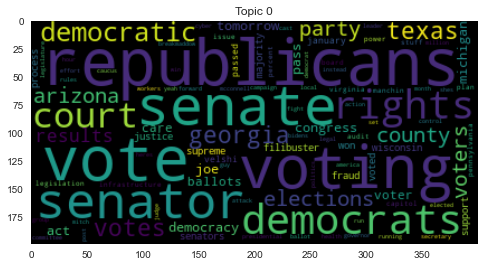

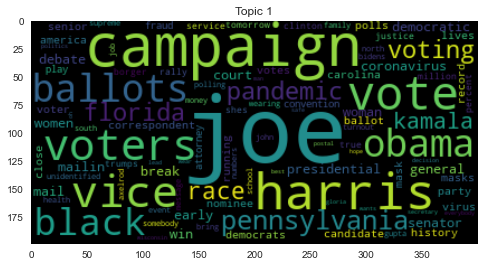

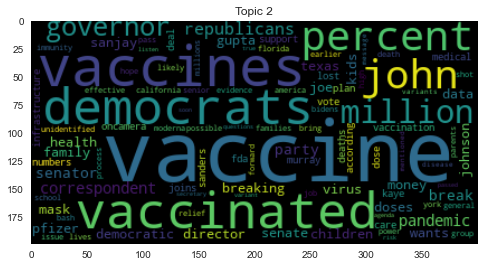

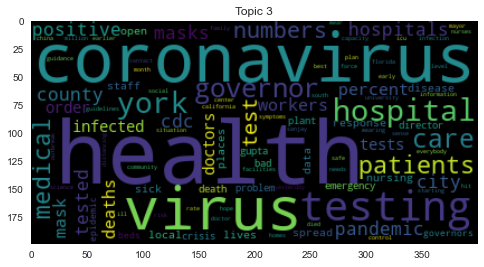

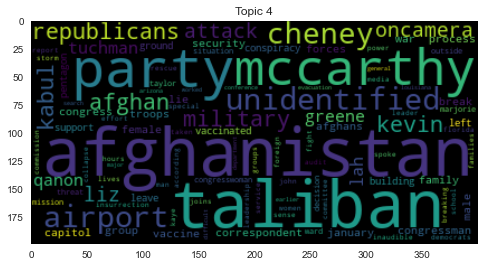

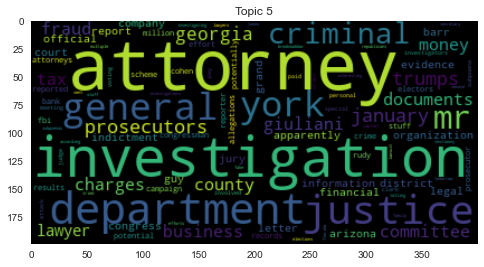

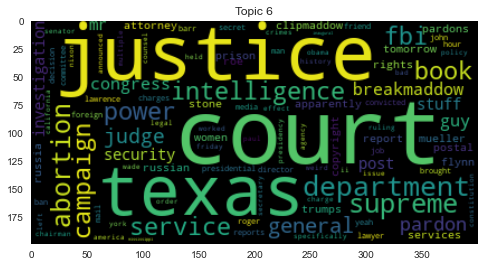

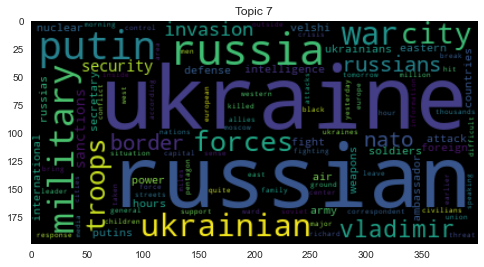

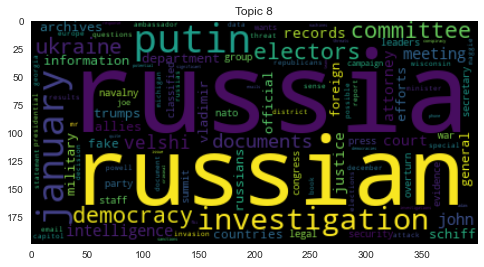

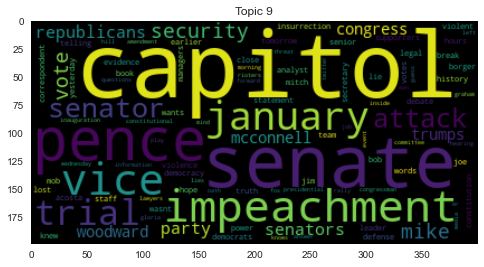

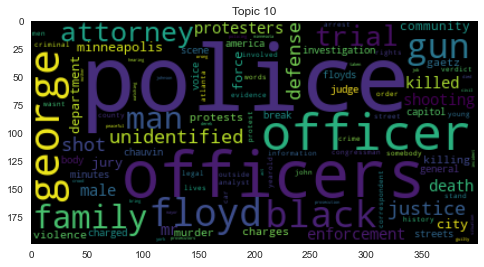

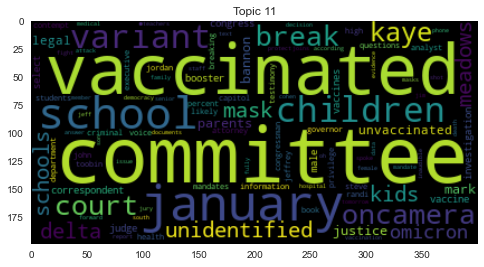

In [85]:
# wordclouds
for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_liberal, topic_word_dist_liberal[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

## Conservative - Transcript Topic Modeling <a name="a3conservativetrans"></a>

In [86]:
# fit with 12 topics
num_topics = 12

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_conservative)

LatentDirichletAllocation(n_components=12, random_state=0)

In [87]:
# normalize to get probability distributions
topic_word_dist_conservative = np.array([row / row.sum() for row in lda.components_])

In [88]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist_conservative[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_conservative[word_idx], topic_word_dist_conservative[topic_idx, word_idx]))


Topic 0:
bream                                                                            0.07918562203302784
shannon                                                                          0.018129548950411134
kilmeade                                                                         0.010715092738744094
shes                                                                             0.005761000294653449
administration                                                                   0.005109344404626941
parents                                                                          0.004885964224464514
school                                                                           0.004437081415858999
kids                                                                             0.004248131474790241
camera                                                                           0.0038449267626848686
afghanistan                                                             

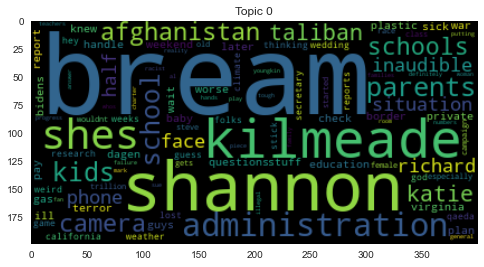

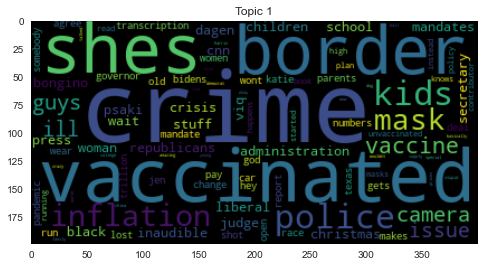

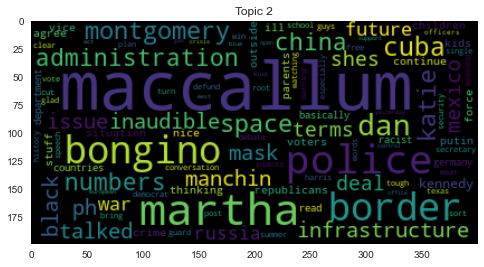

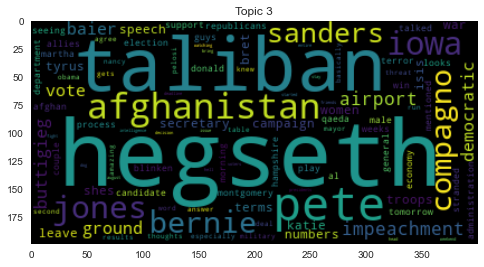

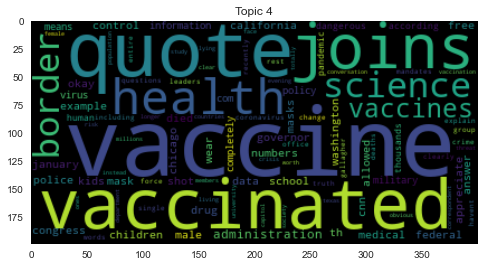

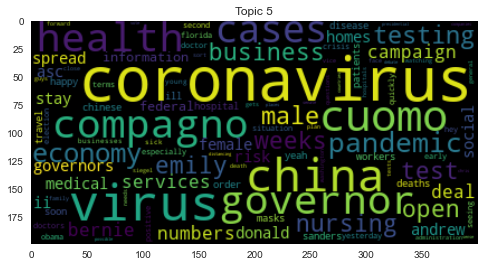

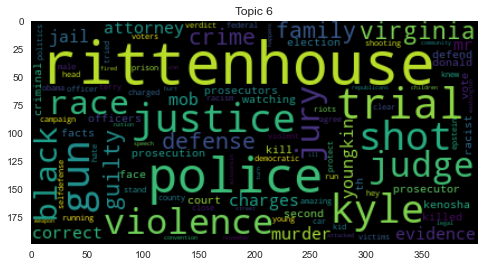

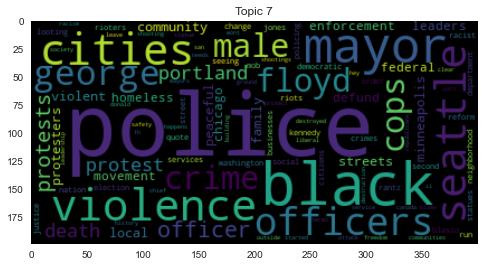

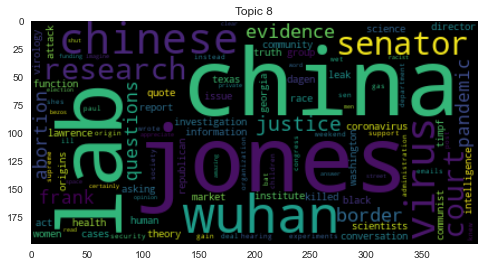

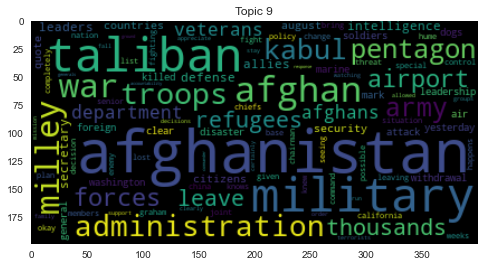

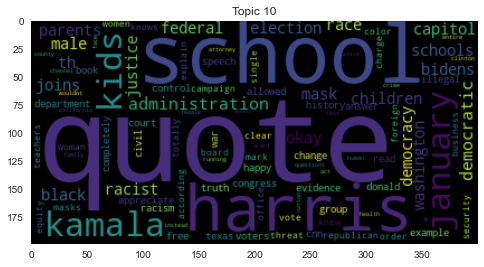

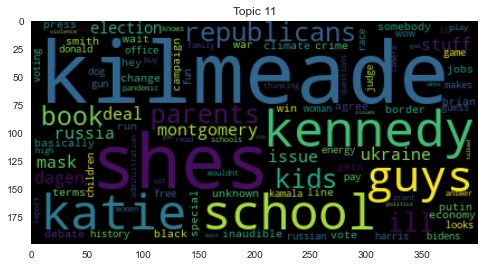

In [89]:
# wordclouds
for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_conservative, topic_word_dist_conservative[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

# Analysis #4: Sentiment Analysis <a name="a4"></a>

The key reason why we chose to do sentiment analysis as part of our project was because we theorized that, while conservative and liberal opinion tlk shows hosts and their guests may use the same words, the tone and sentiment around those words could drastically differ. 

**Background:** For the sentiment analysis portion of our analysis, we used a method called **VADER** (Valence Aware Dictionary and sEntiment Reasoner). The associated python package for this method is **nltk.sentiment**. This method works best on small pieces of data, like sentences, rather than on a longer trasncript. Therefore, the analysis below is organized at the **sentence-level**. Also, because we used a pre-exisiting package, the methodology for assigning "positive" or "negative" sentiments to the sentiments is a bit of a black box to us. If we had further time for this project, we would explore other sentiment analysis packages and compare the results.




### Step 1: Subset the List of Sentences To Just Those That Include COVID Terms 

The goal here is to better understand the context/sentiment around how covid is discussed in the liberal, conservative, and cdc corpuses.

In [ ]:
covid_sentences_liberal = [sentence for sentence in text_sentences_liberal if any(word in sentence for word in covid_terms)]
covid_sentences_conservative = [sentence for sentence in text_sentences_conservative if any(word in sentence for word in covid_terms)]

### Step 2: Apply the Sentiment Analyzer

In [ ]:
sia = SentimentIntensityAnalyzer()

#define a function to run the sentiment analysis
def apply_sentiment_analysis(covid_sentences):
    total_compound_scores = []
    positive_sentences = []
    negative_sentences = []
    neutral_sentences = []
    #first 5 sentences test
    for sentence in covid_sentences:
        score = sia.polarity_scores(sentence)
        compound_score = score["compound"]
        total_compound_scores.append(compound_score)

        if compound_score == 0:
            neutral_sentences.append((sentence, score))
        elif compound_score > 0:
            positive_sentences.append((sentence, score))
        else: 
            negative_sentences.append((sentence, score))


    return total_compound_scores, positive_sentences, negative_sentences, neutral_sentences

In [ ]:
#store all of the results from running sentiment analysis
total_compound_scores_liberal, positive_sentences_liberal, negative_sentences_liberal, neutral_sentences_liberal = apply_sentiment_analysis(covid_sentences_liberal)
total_compound_scores_conservative, positive_sentences_conservative, negative_sentences_conservative, neutral_sentences_conservative = apply_sentiment_analysis(covid_sentences_conservative)

### Step 3: Plot The Distribution of Sentence Sentiments

In [ ]:
#create a function for ploting
def plot_sentiment_dist(positive, neutral, negative, pol_color, plot_title):

    total_num_sentences = len(positive + neutral + negative)

    plt.style.use('seaborn')  

    x = ["positive", "neutral", "negative"]
    y = [len(positive)/total_num_sentences, len(neutral)/total_num_sentences, len(negative)/total_num_sentences]
    plt.bar(x,y, color = pol_color)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) #make the y-axis a percent
    plt.xlabel('Sentiment')
    #plt.xticks(rotation=45)
    plt.ylabel('Percent of Total Setences')
    plt.title(plot_title + " (Total Sentences = {:,})".format(total_num_sentences) )

    plt.show()

In [ ]:
#plot the liberal sentiment analysis distribution
plot_sentiment_dist(positive_sentences_liberal, neutral_sentences_liberal, negative_sentences_liberal, "cornflowerblue",'Distribution of Sentiment in Liberal Corpus')

In [ ]:
#plot the conservative sentiment analysis distribution
plot_sentiment_dist(positive_sentences_conservative, neutral_sentences_conservative, negative_sentences_conservative, "darkred", 'Distribution of Sentiment in Conservative Corpus

# Policy Implications <a name="policy"></a>

**INSERT SOMETHING HERE ABOUT POLICY IMPLICATIONS**
1. LALALA
2. OOHH LOOK AT MEEEEE, I'M POLICY RELATED

# Future Work & Analysis Limitations <a name="future"></a>

**Future Work**
1. Look at transcripts of **local news channels** instead of national news channels to get a better approximation of localized opinions about COVID-19 and its associated mitigation strategies
    - This matches the way that COVID-19 mitigation is being addressed now – on a case by case, local level
2. Expand to look at more **change over time** in the coverage of COVID-19 under different presidential administrations instead of lumping them together to see how the discussion of the pandemic has changed over time

**Limitation**
1. By just doing text analysis, the **context** and **tone** surrounding the words is absent
    - We found that the words used across the liberal and conservative news channels is the same but the context in which its being used or the tone with which the words are used could be different (and meaningfully so) but this is unable to be captured through only text analysis